# nomao dataset 

In [1]:
# Imports
import numpy as np
import pandas as pd

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval import (
    AME,
    DVRL,
    BetaShapley,
    DataBanzhaf,
    DataOob,
    DataShapley,
    InfluenceFunctionEval,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)

from opendataval.experiment import ExperimentMediator

import warnings
warnings.filterwarnings("ignore")

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


## [Step 1] Set up an environment
`ExperimentMediator` is a fundamental concept in establishing the `opendataval` environment. It empowers users to configure hyperparameters, including a dataset, a type of synthetic noise, and a prediction model. With  `ExperimentMediator`, users can effortlessly compute various data valuation algorithms.

The following code cell demonstrates how to set up `ExperimentMediator` with a pre-registered dataset and a prediction model.
- Dataset: nomao
- Model: sklearn's logistic regression model
- Metric: F1-score

In [2]:
dataset_name = "nomao"
train_count, valid_count, test_count = 1000, 100, 500
noise_rate = 0.2
noise_kwargs = {'noise_rate': noise_rate}
model_name = "sklogreg"
metric_name = "f1_score"

exper_med = ExperimentMediator.model_factory_setup(
    dataset_name=dataset_name,
    cache_dir="../data_files/",  
    force_download=False,
    train_count=train_count,
    valid_count=valid_count,
    test_count=test_count,
    add_noise=mix_labels, 
    noise_kwargs=noise_kwargs,
    train_kwargs={},
    model_name=model_name,
    metric_name=metric_name
)

Base line model metric_name='f1_score': perf=0.9470827579498291


A full list of registered datasets can be found [here](https://github.com/opendataval/opendataval/blob/main/opendataval/dataloader/fetcher.py#L121). A list of available  prediction models can be found [here](https://github.com/opendataval/opendataval/blob/main/opendataval/model/__init__.py#L111).

## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [3]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
    InfluenceFunctionEval(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
#     DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Data-Shapley
#     BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Beta-Shapley
#     DataBanzhaf(num_models=1000), # Data-Banzhaf
#     AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000), # Data-OOB
    LavaEvaluator(),
#     RobustVolumeShapley(mc_epochs=300)
]

In [4]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.000460


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 43.45it/s]


Elapsed time LeaveOneOut(): 0:00:23.046561


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 53.28it/s]


Elapsed time InfluenceFunctionEval(num_models=1000): 0:00:18.772091


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 167.13it/s]


Elapsed time DVRL(rl_epochs=2000): 0:00:12.060585


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 11329.58it/s]


Elapsed time KNNShapley(k_neighbors=100): 0:00:00.191936


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.70it/s]


Elapsed time DataOob(num_models=1000): 0:00:30.584991


Elapsed time LavaEvaluator(): 0:00:00.120727
CPU times: user 4min 7s, sys: 1min 22s, total: 5min 30s
Wall time: 1min 24s


## [Step 3] Evaluate data values

In [5]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/nomao_noise_rate=0.2/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: mislabeled data

In [6]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
DVRL(rl_epochs=2000),0.711297
DataOob(num_models=1000),0.326923
InfluenceFunctionEval(num_models=1000),0.275072
KNNShapley(k_neighbors=100),0.507353
LavaEvaluator(),0.118577
LeaveOneOut(),0.045045
RandomEvaluator(),0.294798


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

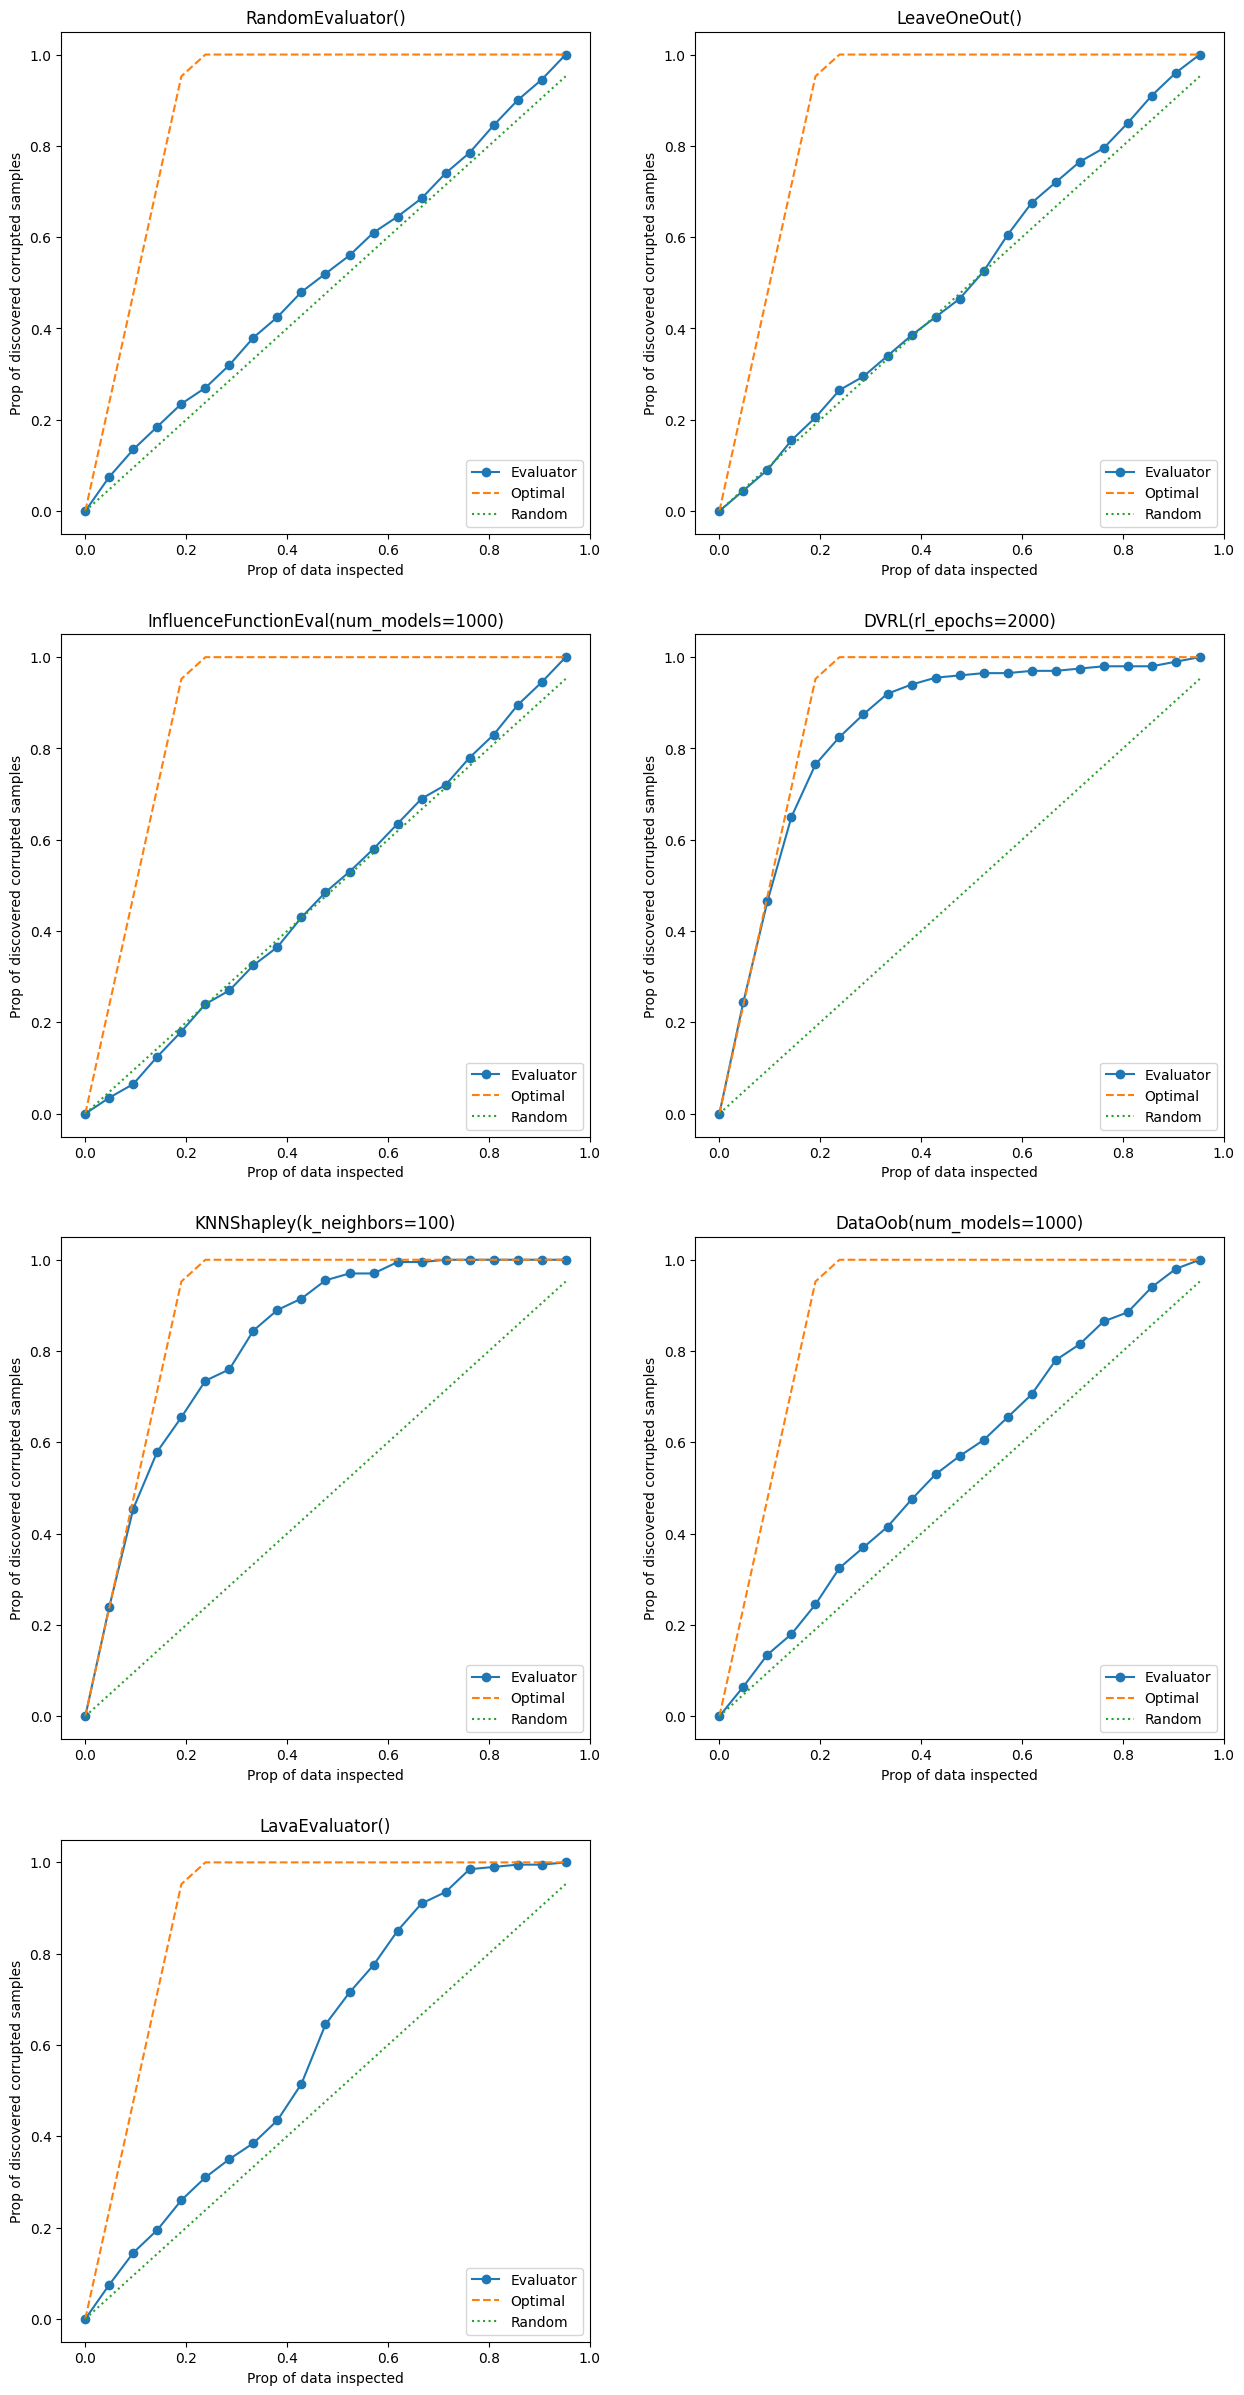

In [7]:
fig = plt.figure(figsize=(15, 30))
df, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

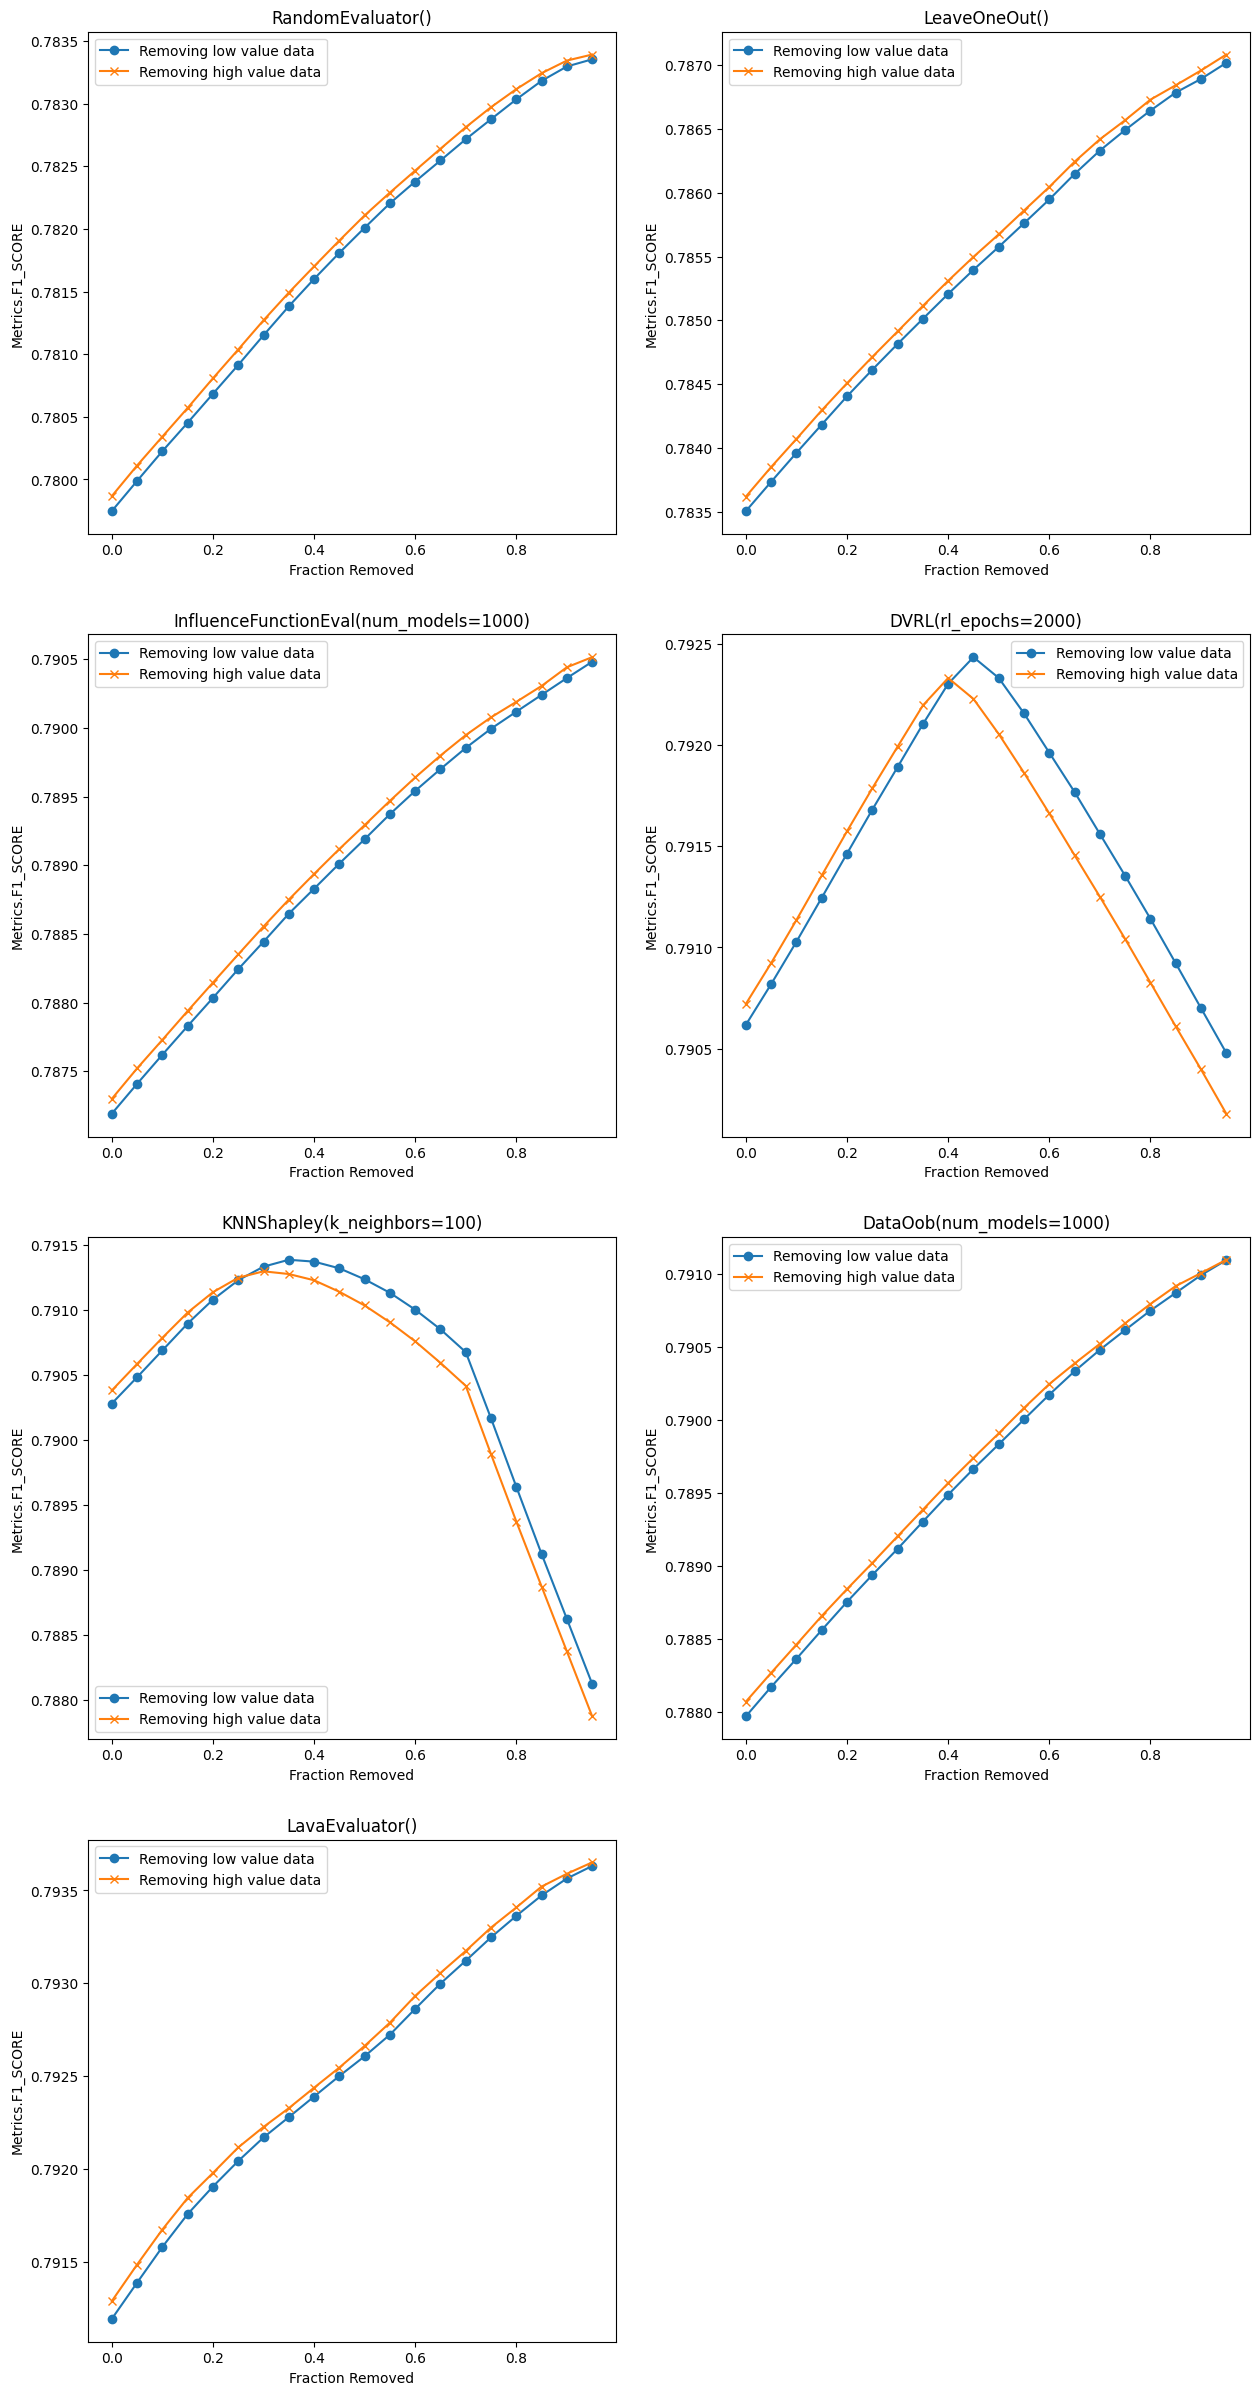

In [8]:
fig = plt.figure(figsize=(15, 30))
df_resp, fig = exper_med.plot(remove_high_low, fig, include_train=True, col=2, save_output=True)

In [9]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.F1_SCORE,remove_most_influential_first_Metrics.F1_SCORE,axis
RandomEvaluator(),0.779748,0.779867,0.0
RandomEvaluator(),0.779988,0.780111,0.05
RandomEvaluator(),0.780226,0.780342,0.1
RandomEvaluator(),0.780453,0.780571,0.15
RandomEvaluator(),0.780684,0.780807,0.2
...,...,...,...
LavaEvaluator(),0.793247,0.7933,0.75
LavaEvaluator(),0.793363,0.793408,0.8
LavaEvaluator(),0.793473,0.793521,0.85
LavaEvaluator(),0.793564,0.79359,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [10]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),10867,0.400609
RandomEvaluator(),26265,0.290831
RandomEvaluator(),4983,0.653107
RandomEvaluator(),19323,0.585661
RandomEvaluator(),7928,0.717716
...,...,...
LavaEvaluator(),5175,15.228195
LavaEvaluator(),11147,10.797821
LavaEvaluator(),11592,11.917761
LavaEvaluator(),24875,9.497479
